# Redes convolucionales para PLN

In [1]:
#imports
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Revision del dataset

In [2]:
movie_reviews = pd.read_csv('IMDB Dataset.csv')

movie_reviews.isnull().values.any()

movie_reviews.shape

movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#Miremos un ejemplo
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [4]:
#Veremos como esta compuesto el dataset
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [5]:
#Limpieza de los textos
def preprocess_text(sen):
    # Quitando html
    sentence = remove_tags(sen)

    # Quitando numeros y puntos
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Quitando caracteres individuales
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Quitando espacios innecesarios
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
#hago un nuevo array con los textos limpios
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
#Veamos como quedo
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [6]:
#Normalizo las etiquetas Positivo:1 y Negativo:0
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [7]:
#Divido le data set en train 80% y test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [8]:
#Tokenizar los datos
from sklearn.externals import joblib 

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
joblib.dump(tokenizer, 'tokenizerCNN.pkl')
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Segundo bloque
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [10]:
#Comenzando con el modelo
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [11]:
history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/15
32000/32000 [==============================] - 56s 2ms/step - loss: 0.5490 - acc: 0.7202 - val_loss: 0.4730 - val_acc: 0.7758
Epoch 2/15
32000/32000 [==============================] - 55s 2ms/step - loss: 0.4530 - acc: 0.7894 - val_loss: 0.4831 - val_acc: 0.7582
Epoch 3/15
32000/32000 [==============================] - 54s 2ms/step - loss: 0.4047 - acc: 0.8156 - val_loss: 0.3903 - val_acc: 0.8311
Epoch 4/15
32000/32000 [==============================] - 54s 2ms/step - loss: 0.3662 - acc: 0.8375 - val_loss: 0.3586 - val_acc: 0.8396
Epoch 5/15
32000/32000 [==============================] - 55s 2ms/step - loss: 0.3406 - acc: 0.8516 - val_loss: 0.3437 - val_acc: 0.8525
Epoch 6/15
32000/32000 [==============================] - 54s 2ms/step - loss: 0.3172 - acc: 0.8618 - val_loss: 0.3409 - val_acc: 0.8516
Epoch 7/15
32000/32000 [==============================] - 54s 2ms/step - loss: 0.3026 - acc: 0.8717 - val_loss: 0.3347 - val_acc:

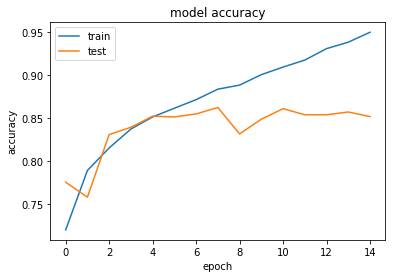

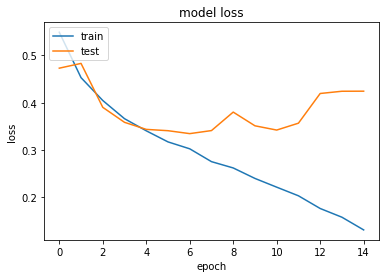

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [13]:
# Persisto el modelo
model.save("modelo_CNN.h5")


In [14]:
#testeo una predicción
instance = X[24]
print(instance)

This was the worst movie saw at WorldFest and it also received the least amount of applause afterwards can only think it is receiving such recognition based on the amount of known actors in the film It great to see Beals but she only in the movie for few minutes Parker is much better actress than the part allowed for The rest of the acting is hard to judge because the movie is so ridiculous and predictable The main character is totally unsympathetic and therefore bore to watch There is no real emotional depth to the story movie revolving about an actor who can get work doesn feel very original to me Nor does the development of the cop It feels like one of many straight to video movies saw back in the And not even good one in those standards 


In [15]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.9935847]], dtype=float32)